In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from google.colab import drive

import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

#### Load the Data

In [ ]:
# drive.mount('/content/drive')

# # Load from Google Drive
# df = pd.read_csv('/content/drive/MyDrive/processed_reviews.tsv')

Mounted at /content/drive


In [ ]:
# Load from local file
df = pd.read_csv('../data/02_preprocessed_data/processed_reviews.tsv', sep='\t', on_bad_lines='skip', low_memory=False) 

In [4]:
df.head()

,customer_id,review_id,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,...,is_top_reviewer,product_avg_rating,rating_deviation,is_bad_reviewers,sentiment_polarity,sentiment_subjectivity,readability,hedge_count,hedged,review_age_bin
0,12076615,RQ58W7SMO911M,4.0,2.0,3.0,0,0,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14,...,0,4.596886,0.596886,0,0.240476,0.469615,70.424738,3,1,"(76.983, 179.7]"
1,12703090,RF6IUKMGL8SF,3.0,5.0,5.0,0,0,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14,...,0,4.000000,1.000000,0,0.232812,0.583333,80.690000,1,1,"(76.983, 179.7]"
2,12257412,R1DOSHH6AI622S,4.0,1.0,22.0,0,0,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14,...,0,4.500000,0.500000,0,0.300000,0.425000,62.876316,0,0,"(76.983, 179.7]"
3,50732546,RATOTLA3OF70O,5.0,2.0,2.0,0,0,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14,...,1,5.000000,0.000000,0,0.181884,0.410145,50.301733,1,1,"(76.983, 179.7]"
4,51964897,R1TNWRKIVHVYOV,4.0,0.0,2.0,0,0,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14,...,0,4.000000,0.000000,0,0.266667,0.528571,60.442157,0,0,"(76.983, 179.7]"


#### Random Forest To Analyze the Features Generated

In [4]:
# Features
features = [
    'star_rating', 'verified_purchase', 'vine', 'review_length', 'review_word_count',
    'headline_length', 'headline_word_count', 'review_age', 'is_top_reviewer',
    'product_avg_rating', 'rating_deviation', 'is_bad_reviewers', 'sentiment_polarity',
    'sentiment_subjectivity', 'readability', 'hedge_count', 'hedged'
]

# Target
target = 'helpful_ratio'

In [ ]:
# Extract features and target variable
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         
    random_state=42,       
    shuffle=True           
)

In [6]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train target mean: {y_train.mean():.4f}, Test target mean: {y_test.mean():.4f}")

Train shape: (1028897, 17), Test shape: (257225, 17)
Train target mean: 0.3657, Test target mean: 0.3657


In [ ]:
# #### Random Forest To Analyze the Features Generated
# Random Forest model to analyze the features generated
rf_model = RandomForestRegressor(
            n_estimators=200,            
            max_depth=10,                
            min_samples_split=5,         
            min_samples_leaf=2,          
            max_features='sqrt',         
            random_state=42,             
            n_jobs=-1,                   
            verbose=1                    
        )

# Fit the model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.0min finished


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42, verbose=1)

In [ ]:
# Evaluate the model
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate and print evaluation metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s


MSE: 0.0550146050922579
R²: 0.1697536678467363


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.4s finished


### PDP Plots

#### Rating + Sentiment Alignment

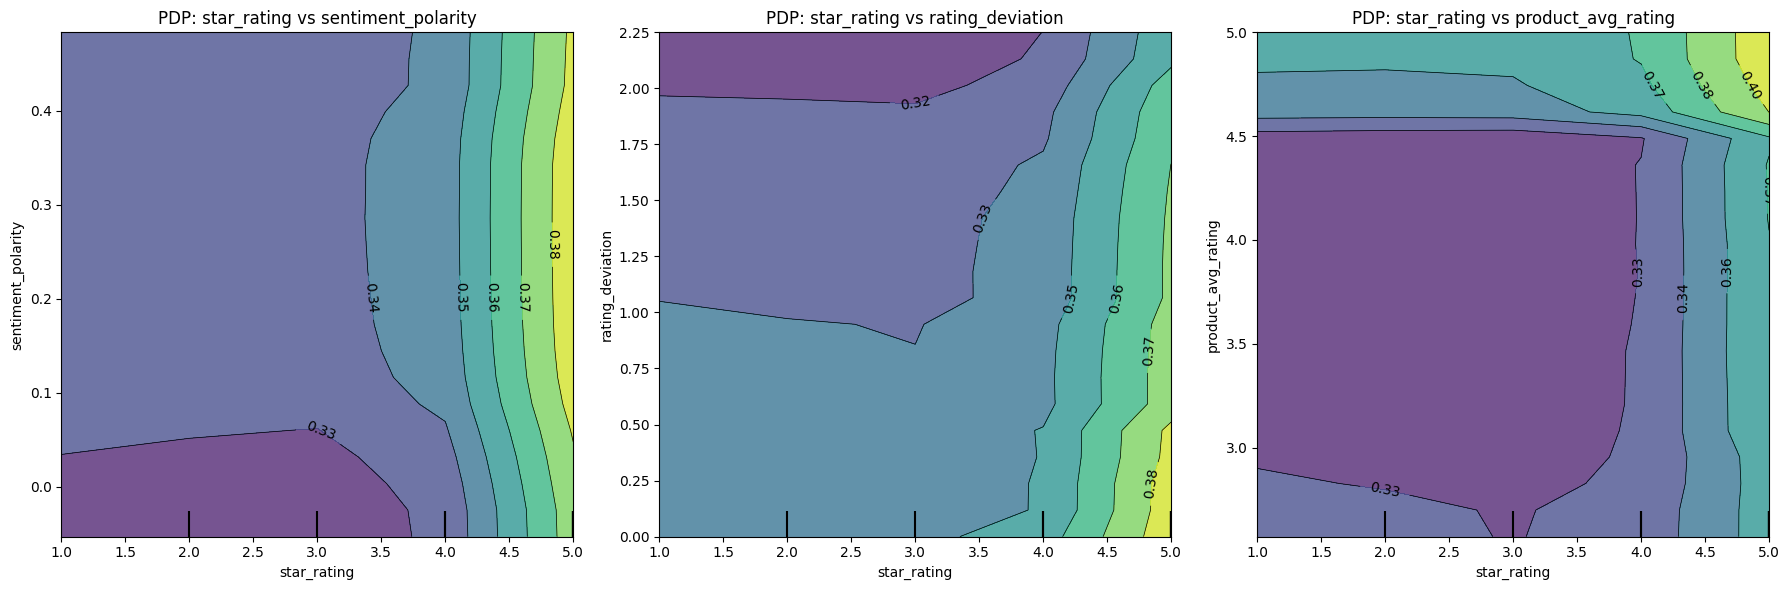

In [ ]:
# Interaction pairs
interactions = [
    ('star_rating',	'sentiment_polarity'),
    ('star_rating', 'rating_deviation'),
    ('star_rating', 'product_avg_rating')
]

# Plot Partial Dependence Plots (PDP) for the interaction pairs
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax = ax.flatten()

for i, pair in enumerate(interactions):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [pair], ax=ax[i], kind='average', grid_resolution=20)
    ax[i].set_title(f"PDP: {pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

#### Length vs. Readability/Confidence

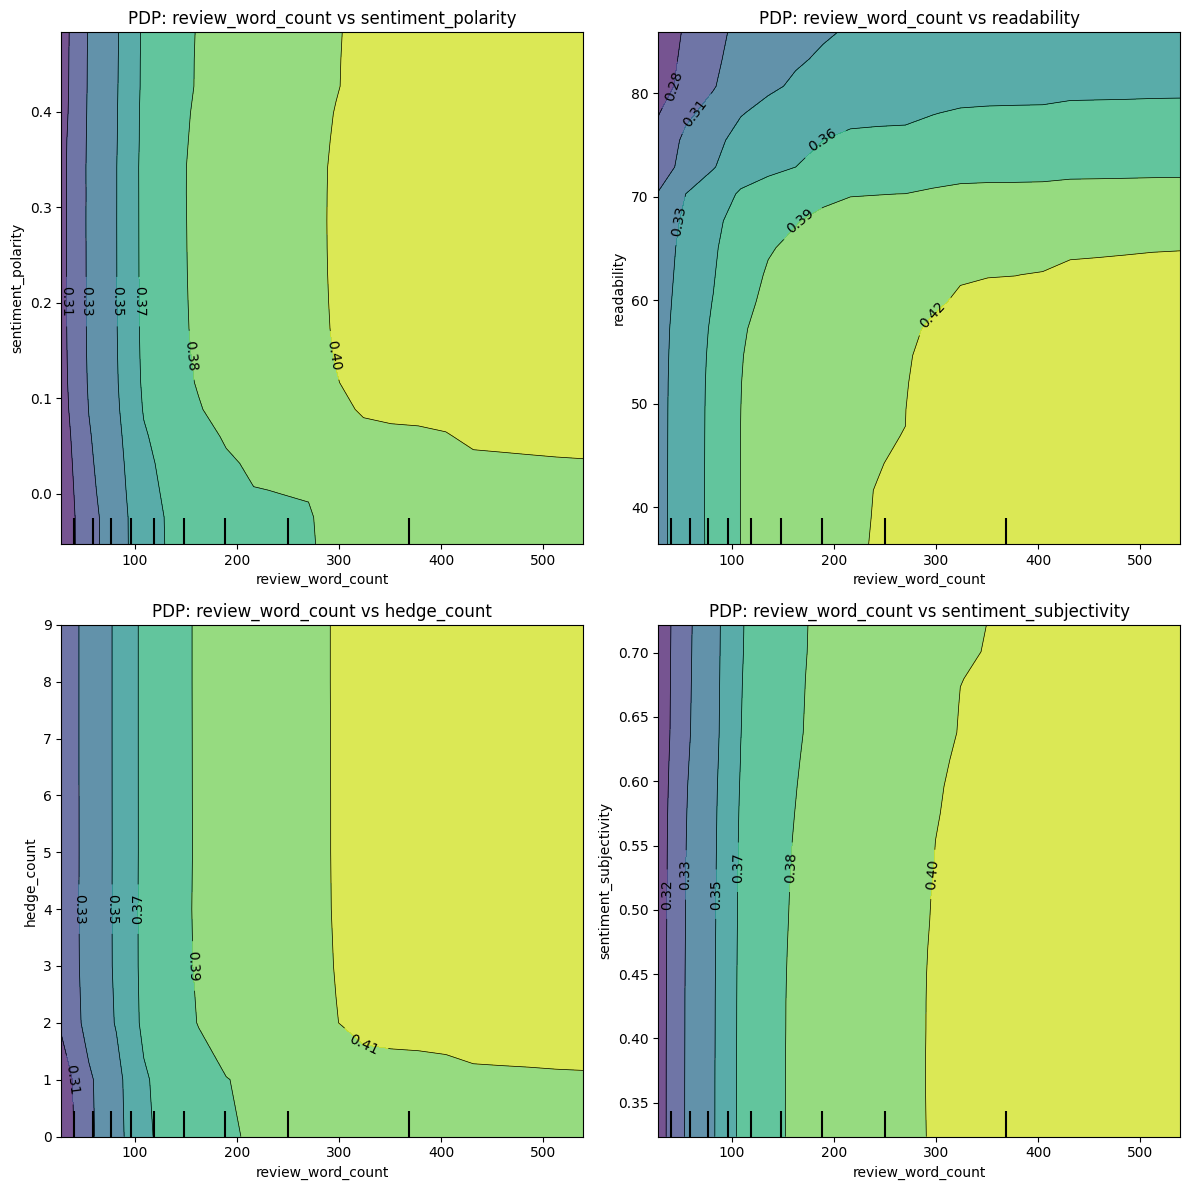

In [ ]:
# Interaction pairs
interactions = [
    ('review_word_count', 'sentiment_polarity'),
    ('review_word_count', 'readability'),
    ('review_word_count', 'hedge_count'),
    ('review_word_count', 'sentiment_subjectivity'),
    ('review_length', 'readability'),
]

# Plot Partial Dependence Plots (PDP) for the interaction pairs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
ax = ax.flatten()

for i, pair in enumerate(interactions):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [pair], ax=ax[i], kind='average', grid_resolution=20)
    ax[i].set_title(f"PDP: {pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

#### User Behavior vs. Content Quality

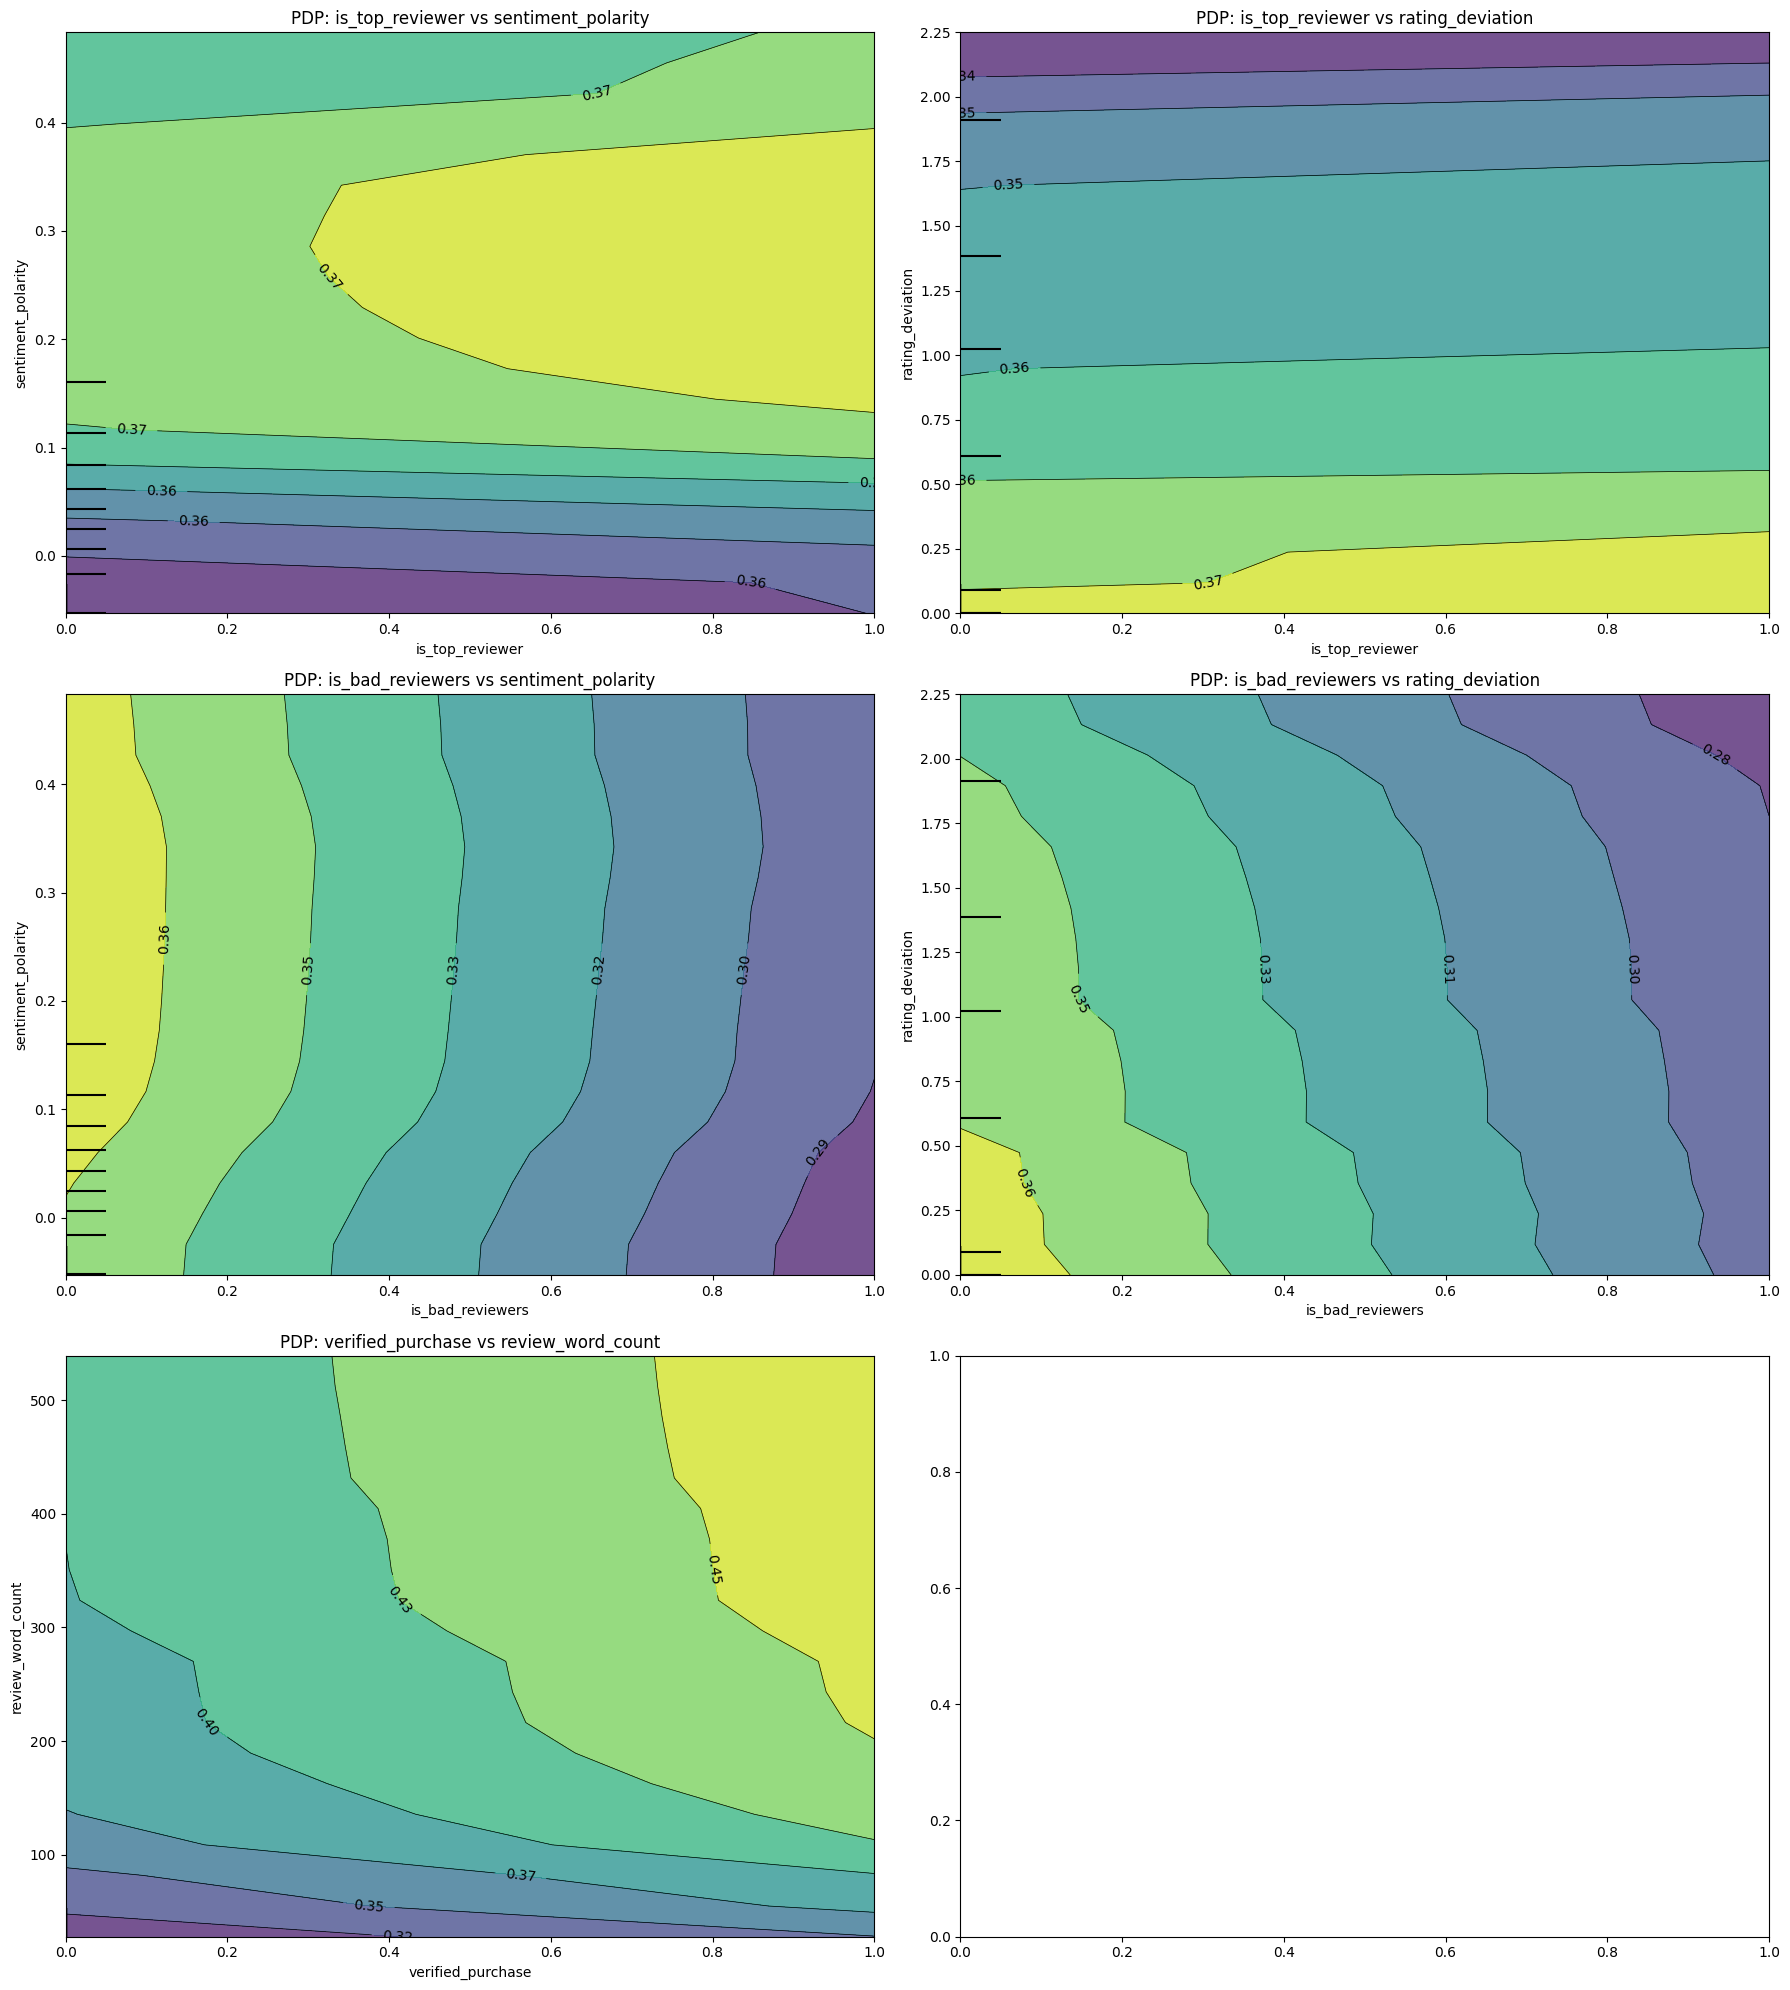

In [ ]:
# Interaction pairs
interactions = [
    ('is_top_reviewer', 'sentiment_polarity'),
    ('is_top_reviewer', 'rating_deviation'),
    ('is_bad_reviewers', 'sentiment_polarity'),
    ('is_bad_reviewers', 'rating_deviation'),
    ('verified_purchase', 'review_word_count'),
]

# Plot Partial Dependence Plots (PDP) for the interaction pairs
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 20))
ax = ax.flatten()

for i, pair in enumerate(interactions):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [pair], ax=ax[i], kind='average', grid_resolution=20)
    ax[i].set_title(f"PDP: {pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

#### Product Popularity vs. Review Quality

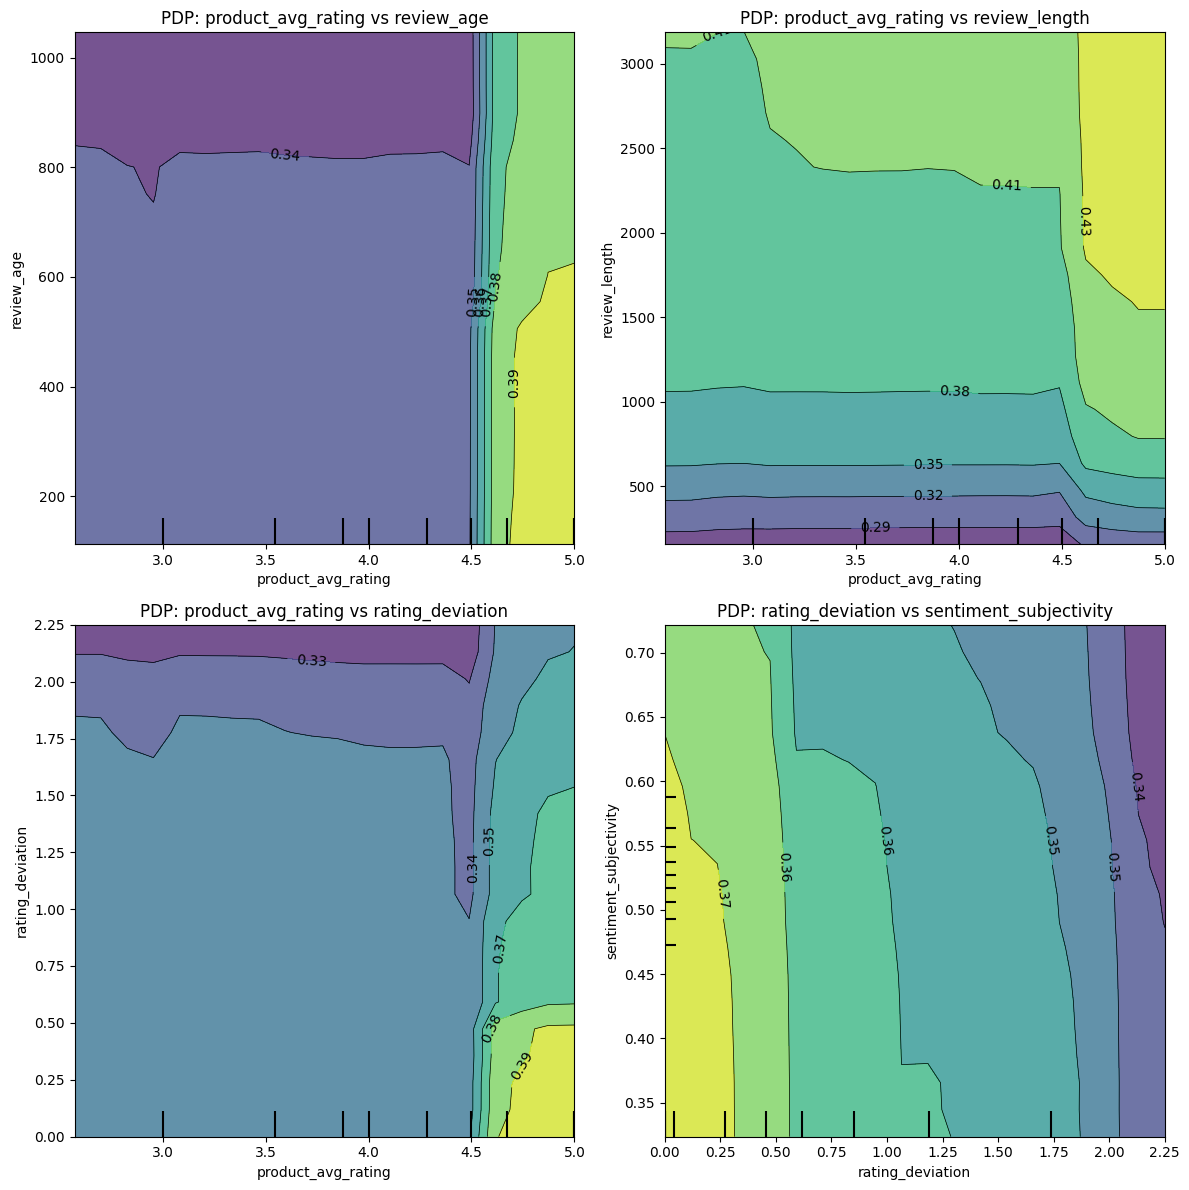

In [ ]:
# Interaction pairs
interactions = [
    ('product_avg_rating', 'review_age'),
    ('product_avg_rating', 'review_length'),
    ('product_avg_rating', 'rating_deviation'),
    ('rating_deviation', 'sentiment_subjectivity')
]

# Plot Partial Dependence Plots (PDP) for the interaction pairs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax = ax.flatten()

for i, pair in enumerate(interactions):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [pair], ax=ax[i], kind='average', grid_resolution=20)
    ax[i].set_title(f"PDP: {pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

#### Confidence vs. Helpfulness

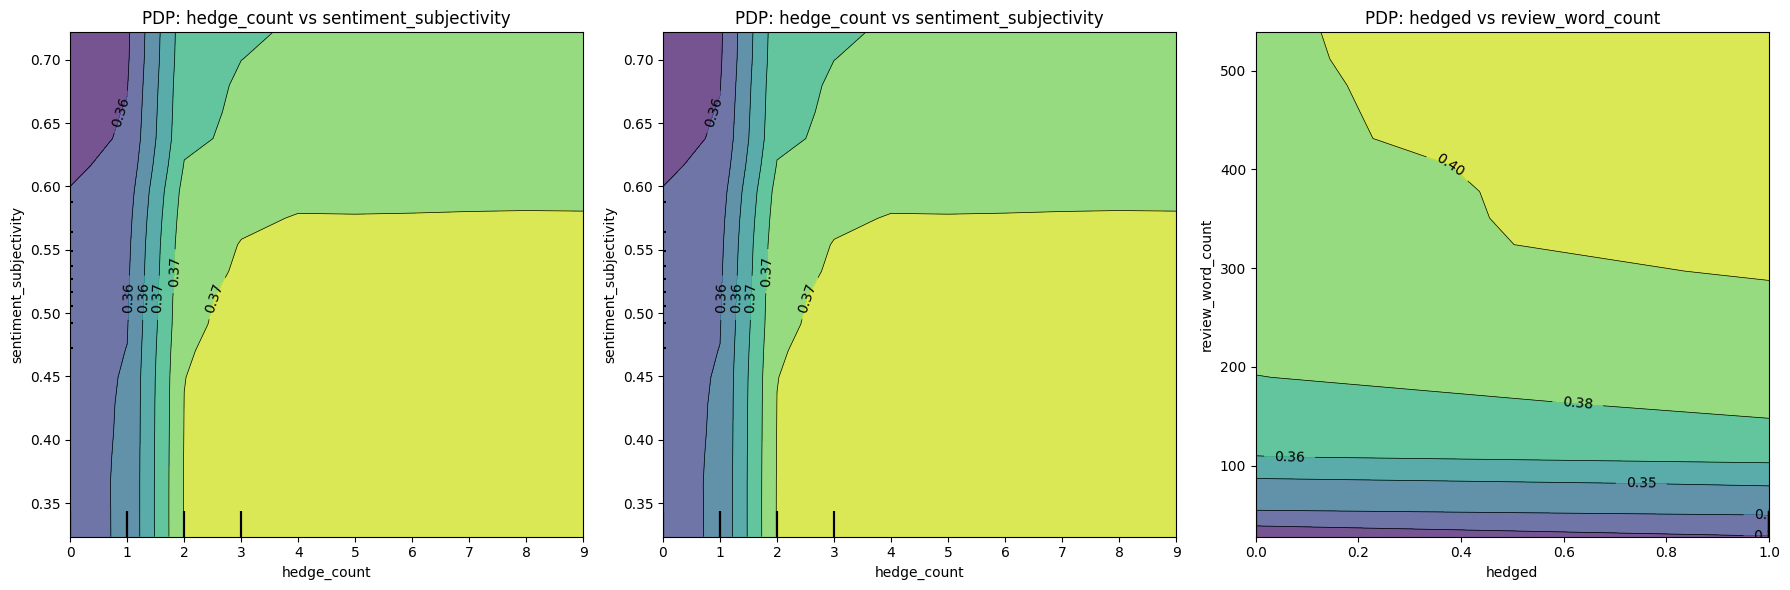

In [ ]:
# Interaction pairs
interactions = [
    ('hedge_count', 'sentiment_subjectivity'),
    ('hedge_count', 'sentiment_subjectivity'),
    ('hedged', 'review_word_count'),
    # ('hedge_count', 'helpful_votes')
]

# Plot Partial Dependence Plots (PDP) for the interaction pairs
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax = ax.flatten()

for i, pair in enumerate(interactions):
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [pair], ax=ax[i], kind='average', grid_resolution=20)
    ax[i].set_title(f"PDP: {pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

#### Newly Generated Features Based on PDP Plots

In [3]:
df["rating_sentiment_gap"] = abs(df["star_rating"] - df["sentiment_polarity"] * 5)
df["length_readability_score"] = df["review_length"] / (df["readability"] + 1e-5)
df["hedging_density"] = df["hedge_count"] / (df["review_word_count"] + 1)
df["deviation_penalty"] = df["rating_deviation"] * df["is_bad_reviewers"]
df["rating_alignment"] = abs(df["star_rating"] - df["product_avg_rating"])
df["avg_rating_amplified_length"] = df["product_avg_rating"] * np.log1p(df["review_length"])

In [4]:
# Add Random Noise
df["random_noise"] = np.random.rand(len(df))

In [5]:
# Final extended feature list
final_features =  [
    'star_rating', 'verified_purchase', 'vine', 'review_length', 'review_word_count',
    'headline_length', 'headline_word_count', 'review_age', 'is_top_reviewer',
    'product_avg_rating', 'rating_deviation', 'is_bad_reviewers', 'sentiment_polarity',
    'sentiment_subjectivity', 'readability', 'hedge_count', 'hedged',
    'rating_sentiment_gap', 'length_readability_score', 'hedging_density',
    'deviation_penalty', 'rating_alignment', 'avg_rating_amplified_length'
]

In [6]:
final_features.append("random_noise")

In [ ]:
# Extract features and target variable
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         
    random_state=42,       
    shuffle=True           
)

In [ ]:
# Re-Train the RandomForest model
updated_rf_model = RandomForestRegressor(
            n_estimators=200,            
            max_depth=10,                
            min_samples_split=5,         
            min_samples_leaf=2,          
            max_features='sqrt',         
            random_state=42,             
            n_jobs=-1,                   
            verbose=1                    
        )

# Fit the updated model
updated_rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.1min finished


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42, verbose=1)

In [ ]:
# Compute feature importances
importances = updated_rf_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

/tmp/ipython-input-4243900621.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")


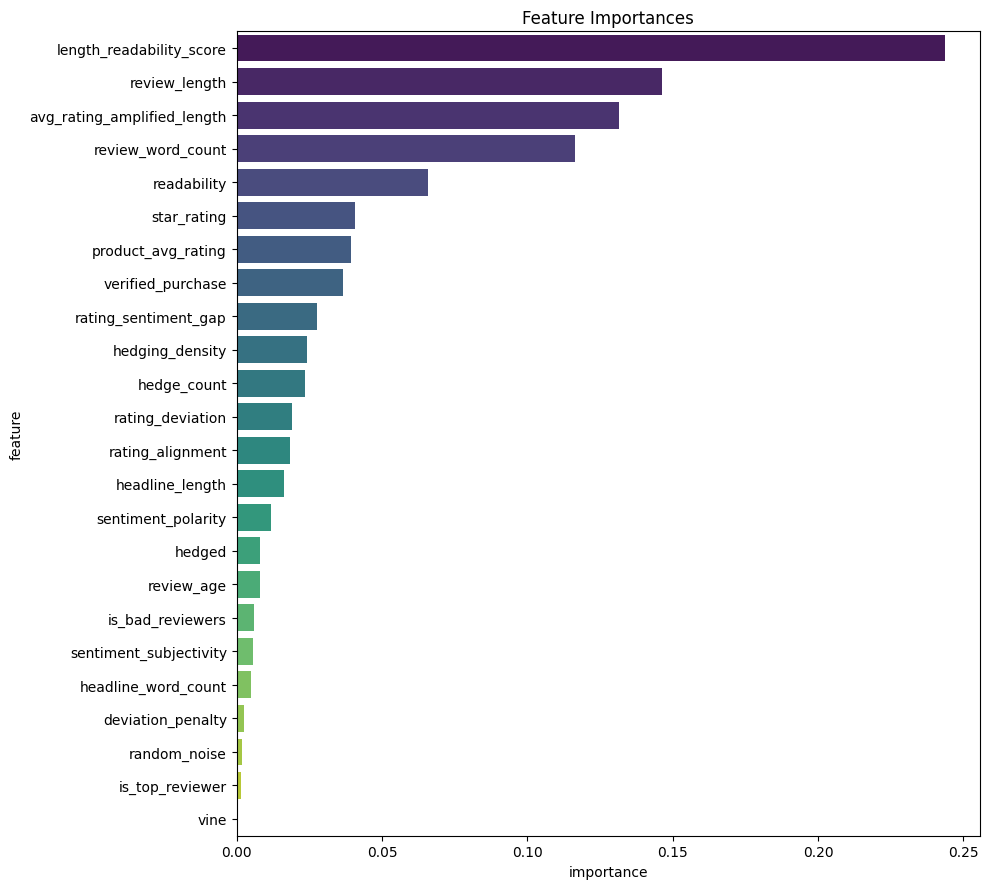

In [10]:
# Plot feature importances
plt.figure(figsize=(10, 9))
sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [12]:
# Initialize the explainer using trained model
explainer = shap.TreeExplainer(updated_rf_model)

In [13]:
# Sample once and reuse
sample_X = X_test.sample(500, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(sample_X)

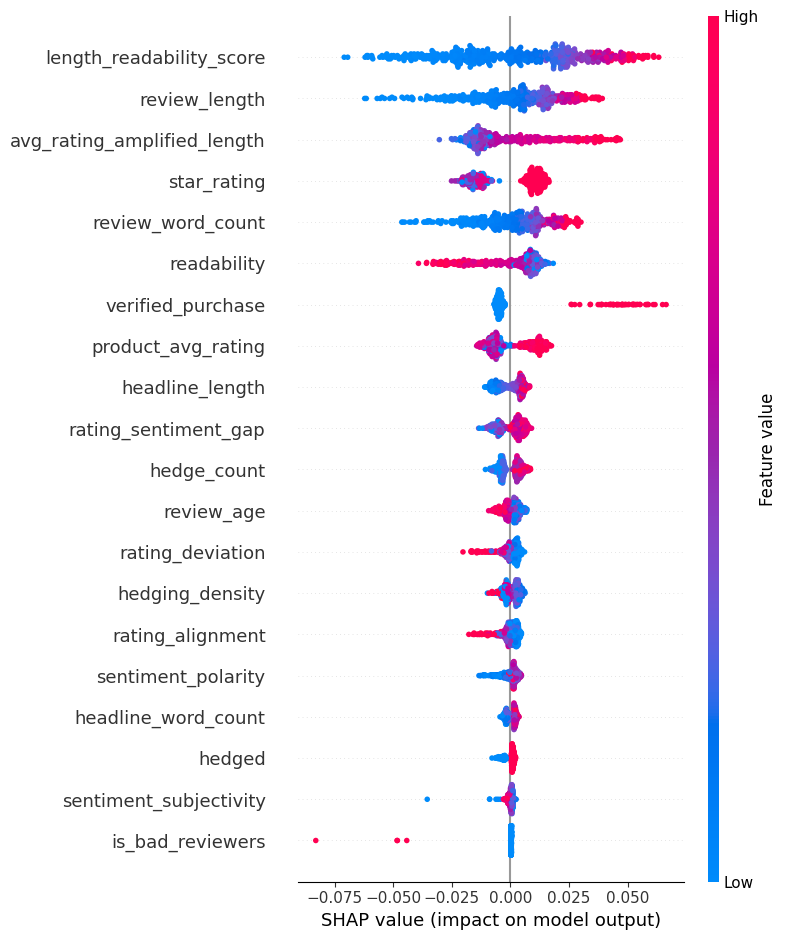

In [14]:
# Plot
shap.summary_plot(shap_values, sample_X, plot_type="dot", max_display=20)

## PDP + SHAP-Based Feature Engineering & Interpretation

To better understand and optimize which features contribute most to predicting review helpfulness, I've used both:

- **2D Partial Dependence Plots (PDPs)** to uncover nonlinear interactions
- **SHAP values** to quantify the impact of each feature on model predictions

---

### Interaction Features Derived from PDP Analysis

| Feature Pair                              | PDP Pattern                  | Insight                                                                 | Engineered Feature                     |
|-------------------------------------------|------------------------------|-------------------------------------------------------------------------|----------------------------------------|
| `star_rating` × `sentiment_polarity`      | Curved ridge                 | High helpfulness when both are aligned and high                        | `rating_sentiment_gap = abs(star_rating - sentiment_polarity * 5)` |
| `review_word_count` × `readability`       | Saddle interaction           | Long reviews are helpful **only** when readable                        | `length_readability_score = review_word_count / (readability + ε)` |
| `review_word_count` × `hedge_count`       | Ridge + penalty zone         | High hedge count reduces usefulness unless review is long              | `hedging_density = hedge_count / (review_word_count + 1)` |
| `is_bad_reviewers` × `rating_deviation`   | Hotspot effect               | Bad reviewers with divergent opinions are least helpful                | `deviation_penalty = rating_deviation * is_bad_reviewers` |
| `product_avg_rating` × `review_length`    | Amplification                | Long reviews more helpful for well-rated books                         | `avg_rating_amplified_length = product_avg_rating * log1p(review_length)` |
| `star_rating` × `product_avg_rating`      | Mild consensus effect        | Agreement with consensus rating matters                                | `rating_alignment = abs(star_rating - product_avg_rating)` |

---

### SHAP Value Analysis: Top Predictive Drivers

SHAP beeswarm plot reveals how feature values influence model output:

#### Top SHAP-Influential Features:
- `length_readability_score` – Clean, readable reviews are most impactful
- `review_length` – Longer reviews tend to be more helpful
- `avg_rating_amplified_length` – Long reviews on highly rated books boost usefulness
- `star_rating` – Higher ratings correlate with higher helpfulness
- `rating_sentiment_gap` – Misalignment between rating and tone lowers trust

#### Sanity Check:
- `random_noise` was excluded from final plot due to no contribution (as expected)
- `is_bad_reviewers`, `sentiment_subjectivity`, and `hedged` were among the least impactful

---

### Final Takeaway

- **Engineered interaction features** improved model interpretability and performance
- **SHAP validation** confirmed that most of the top features came from domain-informed feature engineering
- These insights guide feature selection for the final model, while ensuring generalization and avoiding overfitting



### Get the Top Features

In [15]:
# Extract Important Features from RF
noise_importance = importance_df[importance_df['feature'] == 'random_noise']['importance'].values[0]
filtered_rf_features = importance_df[importance_df['importance'] > noise_importance]['feature'].tolist()

In [16]:
# Get Top SHAP Features
shap_mean_abs = np.abs(shap_values).mean(axis=0)
shap_feature_df = pd.DataFrame({
    'feature': sample_X.columns,
    'mean_abs_shap': shap_mean_abs
# Sort values in dataframe
}).sort_values(by='mean_abs_shap', ascending=False)

# Top SHAP features above noise level
top_shap_features = shap_feature_df.head(20)['feature'].tolist()

In [17]:
# Get the Features
final_features = list(set(filtered_rf_features) & set(top_shap_features))

### Save the Data with the Identifier

In [18]:
df.columns

Index(['customer_id', 'review_id', 'star_rating', 'helpful_votes',
       'total_votes', 'vine', 'verified_purchase', 'review_headline',
       'review_body', 'review_date', 'review_text_full', 'review_length',
       'review_word_count', 'engaged', 'helpful_ratio', 'helpful_class',
       'product_title_mapped', 'year', 'review_age', 'length_bin',
       'headline_length', 'headline_len_bin', 'headline_word_count',
       'headline_word_count_bin', 'is_top_reviewer', 'product_avg_rating',
       'rating_deviation', 'is_bad_reviewers', 'sentiment_polarity',
       'sentiment_subjectivity', 'readability', 'hedge_count', 'hedged',
       'review_age_bin', 'rating_sentiment_gap', 'length_readability_score',
       'hedging_density', 'deviation_penalty', 'rating_alignment',
       'avg_rating_amplified_length', 'random_noise'],
      dtype='object')

In [19]:
# ID Columns
# Map values in column
id_cols = ['review_id', 'customer_id', 'product_title_mapped']

# Ensure all required columns are present
required_cols = id_cols + final_features + ['helpful_ratio']

# Save the Dataframe
df = df[required_cols].copy()

In [ ]:
# Save locally
# file_path = '/content/cleaned_review_features.tsv'
file_path = '../data/03_feature_engineering/cleaned_review_features.tsv'
df.to_csv(file_path, sep='\t', index=False)

In [22]:
# Save to Google Drive
df.to_parquet('/content/drive/MyDrive/cleaned_review_features.parquet', index=False)